In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors

from ecomplexity import ecomplexity
from ecomplexity import proximity

In [11]:
# parameters
window = [2020, 2021]
export_cdf_yearly = False
export_cdf_window = True

# for ecomplexity calculcation
key_cols = {
    "time": "year",
    "loc": "iso2_code",
    "prod": "language",
    "val": "num_pushers",
}


**1 - git complexity**

In [12]:
# data IN
data = pd.read_csv("../data/languages.csv")

In [13]:
# filter functions
def drop_specifics_from_list(data, filter_list):
    """filter specific languages from list -- motivated by RM del Rio-Chanona et al 2023"""
    data = data[~data["language"].str.contains(filter_list, case=False, regex=True)]
    return data

def top_languages_filter(data, nr_languages):
    """keep top x number of languages ONLY"""
    top_languages = data.groupby(["language"])["num_pushers"].agg("sum").reset_index().sort_values(by="num_pushers", ascending=False)
    top_languages = list(top_languages["language"])[:nr_languages]
    data = data[data["language"].isin(top_languages)]
    return data
    
def drop_country_codes_from_list(data, country_list):
    data = data[~data["iso2_code"].isin(country_list)]
    return data

def dataframe_for_ecomplexity(data, focal_year, quarter_list):
    """aggregate and transform dataframe for ecomplexity functions"""
    data = data[(data["year"]==focal_year) & (data["quarter"].isin(quarter_list))]
    data = data\
        .groupby(["year", "iso2_code", "language"])["num_pushers"]\
        .agg("sum")\
        .reset_index()\
        .sort_values(by="num_pushers", ascending=False)    
    return data
    
def add_period_ids(data):
    """create missing semester ID and construct different period IDs"""
    data["semester"] = np.where(data["quarter"] <= 2, 1, 2)
    data["semester_id"] = data["year"].astype(str).str.cat(data["semester"].astype(str), sep="s")
    data["quarter_id"] = data["year"].astype(str).str.cat(data["quarter"].astype(str), sep="q")
    return data

In [14]:
# steps to prep dataframe of ecomplexity
prev_filter = "|".join(["yaml", "json", "text", "svg", "Markdown", "xml"])
df = drop_specifics_from_list(data, filter_list=prev_filter)
df = top_languages_filter(df, nr_languages=150)
df = drop_country_codes_from_list(df, country_list=["EU"])
df = add_period_ids(df)
print(df.shape)

(74289, 9)


In [15]:
# loop to calculate ecomplexity for each year
years = sorted(df["year"].unique())
for y in years:
    df_prep = dataframe_for_ecomplexity(df, focal_year=y, quarter_list=[1, 2, 3, 4])
    cdf = ecomplexity(df_prep, key_cols)
    
    if export_cdf_yearly==True:
        cdf.to_csv(f"../outputs/complexity_table{y}.csv", index=False, sep=";")

2020
2021
2022
2023


In [16]:
# window information
window_data = df[df["year"].isin(window)]  
window_id = '-'.join(map(str, window))
window_data["year"] = window[0]

# ecomplexity for window
df_wprep = dataframe_for_ecomplexity(window_data, focal_year=window[0], quarter_list=[1, 2, 3, 4])
cdf_w = ecomplexity(df_wprep, key_cols)
cdf_w["window"] = window_id
if export_cdf_window==True:
    cdf_w.to_csv(f"../outputs/complexity_table{window_id}.csv", index=False, sep=";")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_7152/2845567388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_data["year"] = window[0]


2020


**2 - language space**

In [31]:
# github space
space_df = proximity(df_wprep, key_cols)
# space_df.to_csv("../outputs/space_table.csv", sep=";", index=False)

2020


In [32]:
def edgelist_for_github_space(data, key_columns):
    """transform the ecomplexity proximity output for visualization"""
    data = data[key_columns]

    # drop zero -- non-existing edges
    data = data[data[key_columns[2]] > 0]

    # drop self loops
    data = data[data[key_columns[0]] != data[key_columns[1]]]
    return data

In [33]:
def maximum_spanning_tree(data, key_columns):
    table = data.copy()
    table["distance"] = 1.0 / table[key_columns[2]]
    G = nx.from_pandas_edgelist(table, source = key_columns[0], target = key_columns[1], edge_attr = ["distance", key_columns[2]])
    T = nx.minimum_spanning_tree(G, weight = "distance")
    table2 = nx.to_pandas_edgelist(T)
    table2 = table2[table2[key_columns[2]] > 0]
    table2.rename(columns = {"source": key_columns[0], "target": key_columns[1], key_columns[2]: "score"}, inplace = True)
    table = pd.merge(
        table,
        table2,
        on=key_columns[0:2]
    )  
    table["edge"] = table.apply(lambda x: "%s-%s" % (min(x[key_columns[0]], x[key_columns[1]]), max(x[key_columns[0]], x[key_columns[1]])), axis = 1)
    table = table.drop_duplicates(subset = ["edge"])
    table = table.drop("edge", 1)
    return table[key_columns]

In [34]:
def add_edges(mst_edges, all_edges, nr_edges_to_add):
    # drop mst edges from the full edgelist
    mst_edges["drop"] = 1
    all_edges = pd.merge(
        all_edges,
        mst_edges,
        on = ["language_1", "language_2", "proximity"],
        how="left"
    )
    all_edges = all_edges[all_edges["drop"] != 1].drop(columns="drop")

    # sort and select
    all_edges = all_edges.sort_values(by="proximity", ascending=False).iloc[:nr_edges_to_add]

    # add to mst edgelist
    software_space_el = pd.concat([mst_el, all_edges])
    return software_space_el

In [38]:
# from space table to MST w/ additional edges
space_table = edgelist_for_github_space(space_df, key_columns=["language_1", "language_2", "proximity"])
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")
n_nodes = mst_graph.number_of_nodes()
n_edges = n_nodes * 2
software_space_el = add_edges(mst_el, space_table, nr_edges_to_add=n_edges)

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_7152/2237830232.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)


In [41]:
# export for Herr Wachs
software_space_el.to_csv(f"../outputs/software_space_edgelist{window_id}.csv", index=False, sep=";")

In [97]:
# re-read to show top countries / languages from 2020
cdf = pd.read_csv("../outputs/complexity_table2020.csv", sep=";")

In [23]:
cdf_w[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).head(10)

,eci,iso2_code
5513,2.123035,DE
21158,2.081709,US
7152,2.076468,GB
7003,2.043101,FR
3576,2.026809,CA
4470,1.990240,CN
10132,1.979358,JP
15049,1.957423,NL
3874,1.947688,CH
1043,1.942703,AU


In [8]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).tail(10)

,eci,iso2_code
10366,-1.142982,LA
17750,-1.197457,SO
13064,-1.197457,MW
3124,-1.240106,BZ
2840,-1.240106,BW
2414,-1.240106,BN
10792,-1.240106,LR
1846,-1.240106,BF
1420,-1.240106,BB
12922,-1.240106,MV


In [9]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).head(20)

,pci,language
60,2.735643,Liquid
48,2.718132,Haml
0,2.695782,AMPL
78,2.693775,OpenSCAD
35,2.686750,G-code
57,2.673040,LLVM
115,2.670293,SourcePawn
61,2.653580,Logos
24,2.653580,DTrace
122,2.652053,SystemVerilog


In [10]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).tail(20)

,pci,language
2,0.076234,ASP.NET
14,0.060997,C#
128,-0.000651,TypeScript
110,-0.043670,Shell
92,-0.095134,Python
123,-0.146376,TSQL
58,-0.243049,Less
56,-0.280109,Kotlin
121,-0.325227,Swift
47,-0.435784,Hack


**2 -- complexity visuals**


In [18]:
def mcl_raw_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')

    table = table\
            .sort_values(by=["total"], ascending=False, axis=0)\
            .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    table = np.log10(table)
    table.replace([np.inf, -np.inf], 0, inplace=True)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.tick_params("y", labelsize=size-15)
        ax.tick_params(left = False, bottom = False)

        my_cmap = plt.cm.get_cmap('Blues')
        colors = my_cmap(table.values.tolist())

        sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,table.values.max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, orientation="vertical", pad=0.1, shrink=0.9925, aspect=40, ax=ax)
        cbar.ax.set_ylabel("Number of pushers", size=size)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.tick_params(labelsize=size-5)
        cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
        cbar.set_ticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'])

/opt/homebrew/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


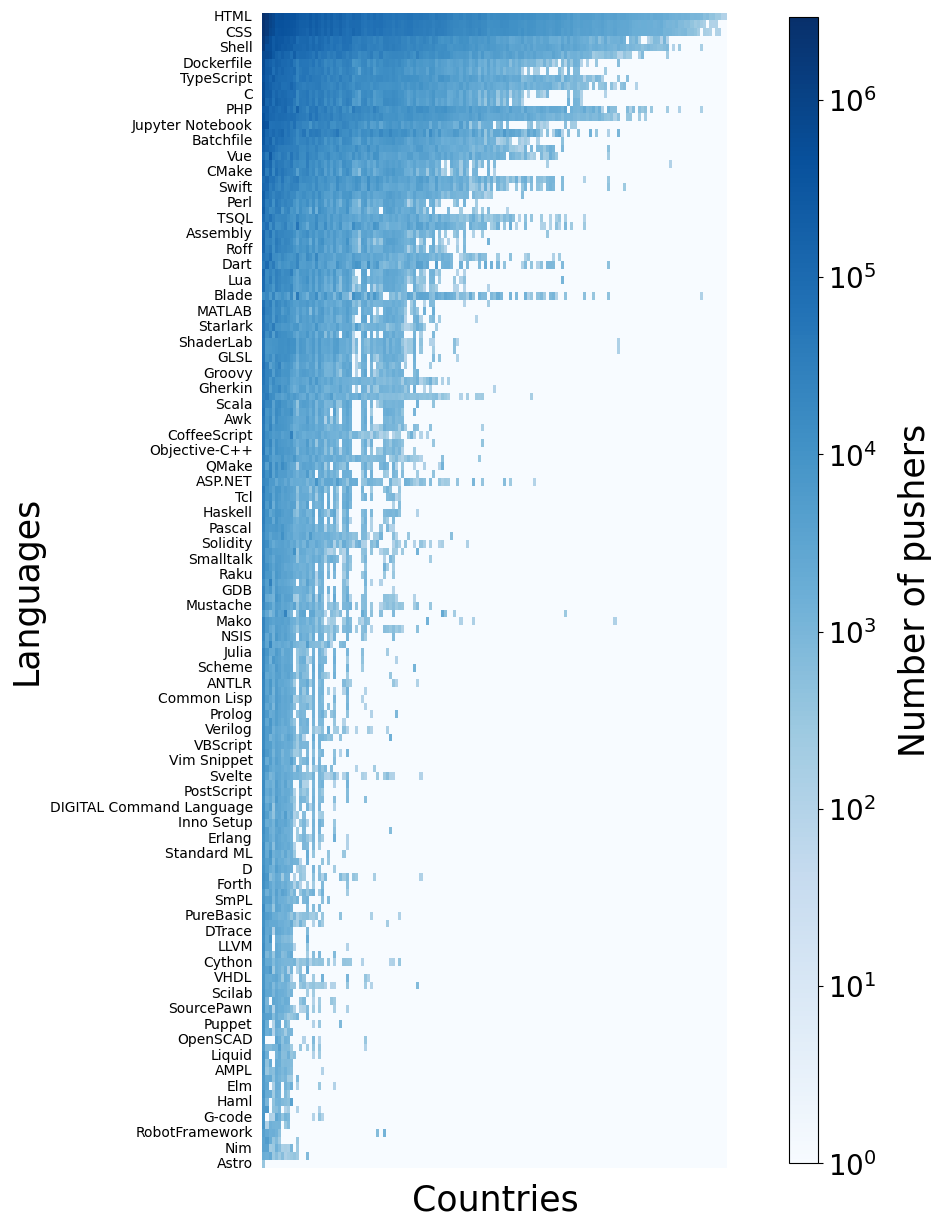

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8, 15))
mcl_raw_matrix(cdf_w, key_columns=["iso2_code", "language", "num_pushers"], heatmap=True, size=25, ax=ax)

In [13]:
def mcl_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    table.loc[table[key_columns[2]] >=1, key_columns[2]] = 1
    table.loc[table[key_columns[2]] < 1, key_columns[2]] = 0
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("RCA", size=size+2)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        

In [14]:
def mcc_matrix(df, key_columns, heatmap, size=18, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()

    mccp = np.dot(t_mat, mat)
    mccp = pd.DataFrame(mccp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).columns))

    if heatmap==False:
        return mccp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mccp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mcc' ", size=size)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Countries", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)


def mll_matrix(df, key_columns, heatmap, size, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()
    mllp = np.dot(mat, t_mat) 
    mllp = pd.DataFrame(mllp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).index))

    if heatmap==False:
        return mllp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mllp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mll' ", size=size+2)
        ax.set_xlabel("Languages", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)



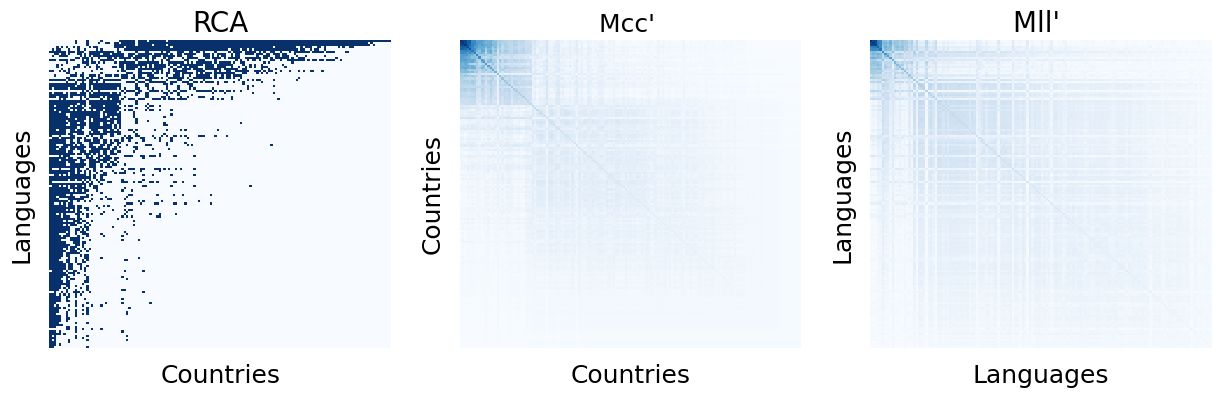

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
mcl_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[0])
mcc_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[1])
mll_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[2])

In [16]:
def diversity_avg_ubiquity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_ubi"] = df["rca01"] * df["ubiquity"]
    df["sum_w_ubi"] = df.groupby(["iso2_code"])["w_ubi"].transform("sum")    
    df["nr_rca01"] = df.groupby(["iso2_code"])["rca01"].transform("sum")
    df["mean_ubi"] = df["sum_w_ubi"] / df["nr_rca01"]

    df = df[["iso2_code", "eci", "diversity", "mean_ubi"]].drop_duplicates()
    #df["eci"] = (df["eci"] - df["eci"].min()) / (df["eci"].max() - df["eci"].min())

    vmin = min(df["eci"])
    vmax = max(df["eci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    eci_values = mapper.to_rgba(df["eci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["diversity"], df["mean_ubi"], color=eci_values, s=55)
    ax.set_xlabel("Language diversity", size=20)
    ax.set_ylabel("Average language ubiquity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

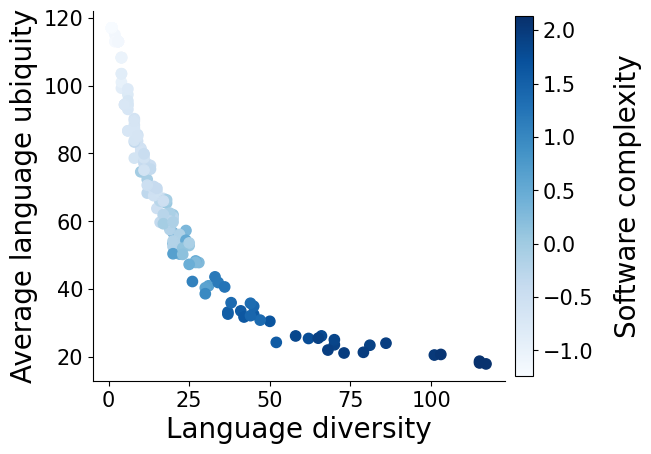

In [17]:
diversity_avg_ubiquity_complexity_scatter(cdf)

In [18]:
def ubiquity_avg_diversity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_div"] = df["rca01"] * df["diversity"]
    df["sum_w_div"] = df.groupby(["language"])["w_div"].transform("sum")
    df["nr_rca01"] = df.groupby(["language"])["rca01"].transform("sum")
    df["mean_div"] = df["sum_w_div"] / df["nr_rca01"]

    df = df[["language", "pci", "ubiquity", "mean_div"]].drop_duplicates()

    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    pci_values = mapper.to_rgba(df["pci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["ubiquity"], df["mean_div"], color=pci_values, s=55)
    ax.set_xlabel("Language ubiquity", size=20)
    ax.set_ylabel("Average language diversity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Language complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

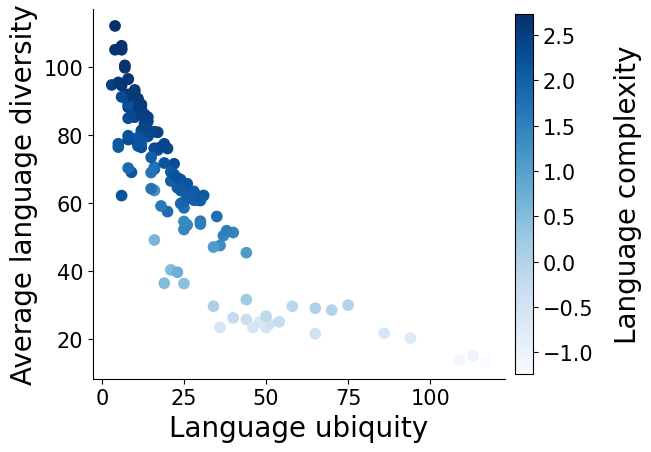

In [19]:
ubiquity_avg_diversity_complexity_scatter(cdf)

In [20]:
def complexity_complexity_matrix(df, heatmap, ax=None):
    # to sort location by eci
    location_sorter = df[["iso2_code", "eci"]]\
        .drop_duplicates()\
        .sort_values(by="eci", ascending=False)

    # only categories w/ RCA
    table = df[df["rca"] >= 1]
    table = table[["iso2_code", "language", "pci"]].drop_duplicates()
    
    table = pd.pivot_table(table,
        values="pci",
        index=["iso2_code"],
        columns=["language"],
        aggfunc=np.mean,
        margins=True,
        margins_name='total')
    
    # add the location_sorter and sort
    table = pd.merge(
        table,
        location_sorter,
        on="iso2_code",
        how="left"
    )

    table = table.sort_values(by=["eci"], ascending=False, axis=0)\
        .set_index("iso2_code")\
        .sort_values(by=["total"], ascending=False, axis=1)

    # remove supporter rows and cols
    table = table.drop(["eci"], axis=1).drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()

    sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
    ax.set_xlabel("Languages sorted by \n their complexity", size=20)
    ax.set_ylabel("Countries sorted by \n their complexity", size=20)
    #ax.set_xticklabels("")
    #ax.set_yticklabels("")
    ax.tick_params(left = False, bottom = False)

    # colorbar settings
    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    cbar = fig.colorbar(mapper, shrink=0.975, pad=0.02, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

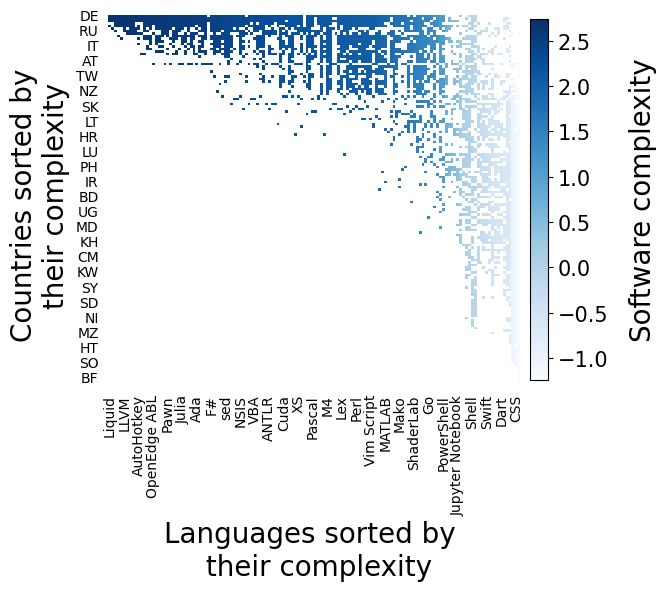

In [21]:
complexity_complexity_matrix(cdf, heatmap=True)

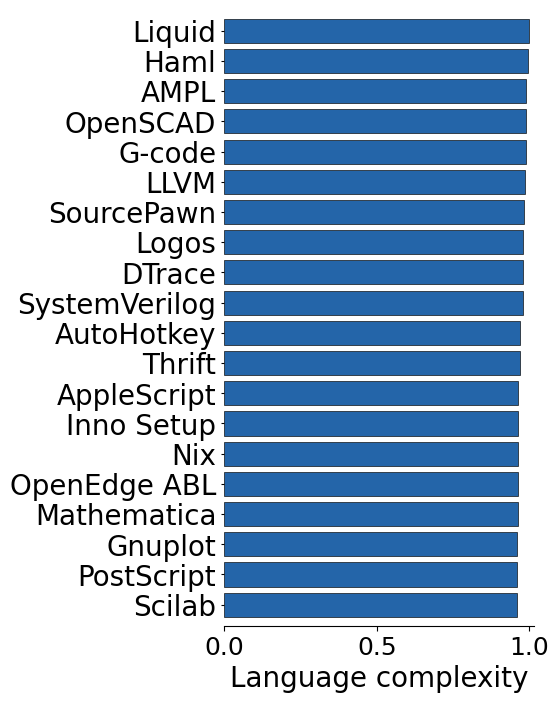

In [22]:
def poi_complexity_plot_top10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_top10(cdf, label_size=20, ax=ax)

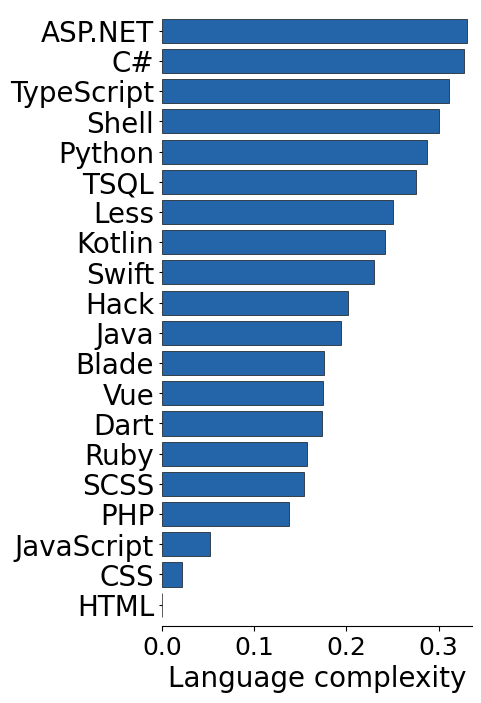

In [23]:
def poi_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["pci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

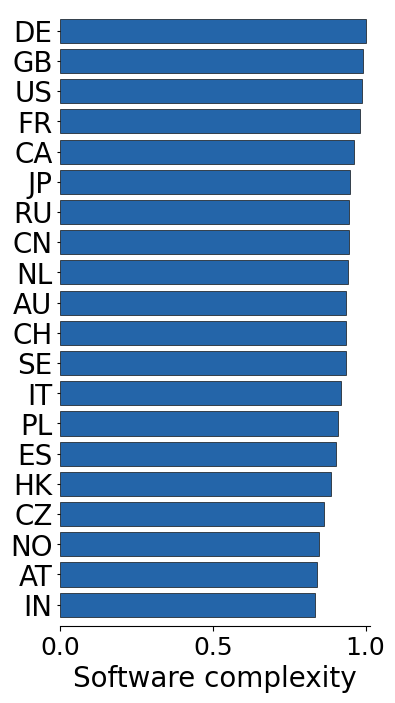

In [24]:
def software_complexity_plot_top10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_top10(cdf, label_size=20, ax=ax)

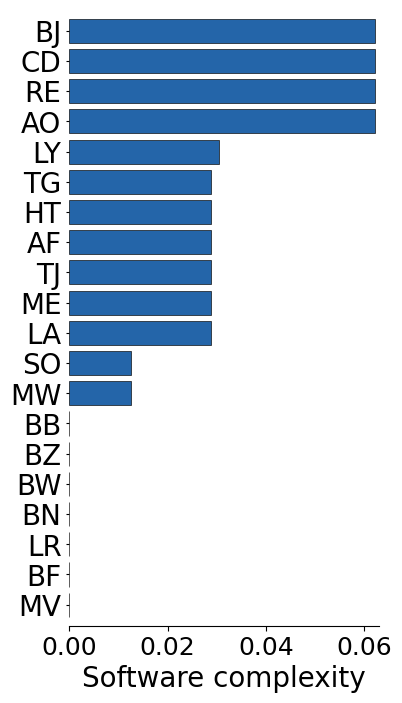

In [25]:
def software_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["eci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

**3 -- github space visuals**

In [26]:
# github space
space_df = proximity(df, key_cols)

2020
2021
2022
2023


/opt/homebrew/lib/python3.10/site-packages/ecomplexity/ComplexityData.py:54: UserWarning: Duplicate values exist, keeping the first occurrence
  warnings.warn("Duplicate values exist, keeping the first occurrence")


In [70]:
# export
space_df.to_csv("../outputs/space_table.csv", sep=";", index=False)

In [71]:
def edgelist_for_github_space(data, key_columns):
    """transform the ecomplexity proximity output for visualization"""
    data = data[key_columns]

    # drop zero -- non-existing edges
    data = data[data[key_columns[2]] > 0]

    # drop self loops
    data = data[data[key_columns[0]] != data[key_columns[1]]]
    return data

space_table = edgelist_for_github_space(space_df, key_columns=["language_1", "language_2", "proximity"])


In [72]:
def maximum_spanning_tree(data, key_columns):
    table = data.copy()
    table["distance"] = 1.0 / table[key_columns[2]]
    G = nx.from_pandas_edgelist(table, source = key_columns[0], target = key_columns[1], edge_attr = ["distance", key_columns[2]])
    T = nx.minimum_spanning_tree(G, weight = "distance")
    table2 = nx.to_pandas_edgelist(T)
    table2 = table2[table2[key_columns[2]] > 0]
    table2.rename(columns = {"source": key_columns[0], "target": key_columns[1], key_columns[2]: "score"}, inplace = True)
    table = pd.merge(
        table,
        table2,
        on=key_columns[0:2]
    )  
    table["edge"] = table.apply(lambda x: "%s-%s" % (min(x[key_columns[0]], x[key_columns[1]]), max(x[key_columns[0]], x[key_columns[1]])), axis = 1)
    table = table.drop_duplicates(subset = ["edge"])
    table = table.drop("edge", 1)
    return table[key_columns]

In [73]:
# NEED to add edges above threshold
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_27520/2237830232.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)


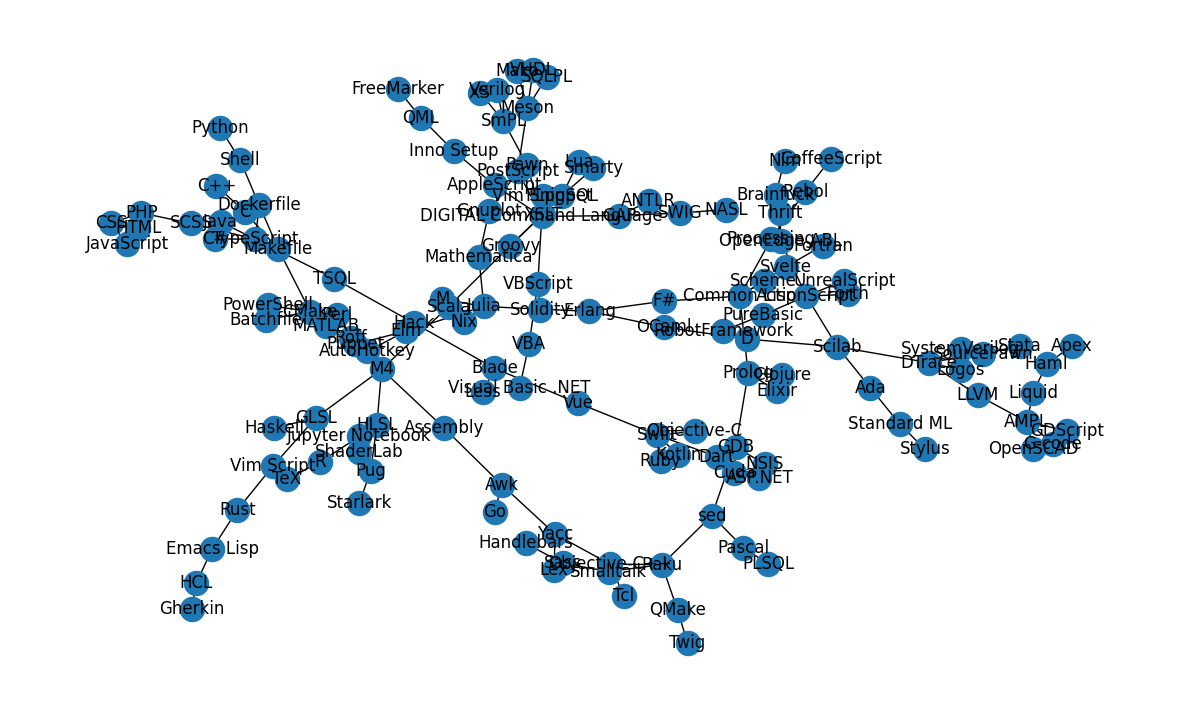

In [74]:
# network visual -- maximum spanning tree
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(mst_graph, with_labels=True, ax=ax)

In [78]:
# figure out numbers
n_nodes = mst_graph.number_of_nodes()
n_edges = n_nodes * 2

In [112]:
def add_edges(mst_edges, all_edges, nr_edges_to_add):
    # drop mst edges from the full edgelist
    mst_edges["drop"] = 1
    all_edges = pd.merge(
        all_edges,
        mst_edges,
        on = ["language_1", "language_2", "proximity"],
        how="left"
    )
    all_edges = all_edges[all_edges["drop"] != 1].drop(columns="drop")

    # sort and select
    all_edges = all_edges.sort_values(by="proximity", ascending=False).iloc[:nr_edges_to_add]

    # add to mst edgelist
    software_space_el = pd.concat([mst_el, all_edges])
    return software_space_el


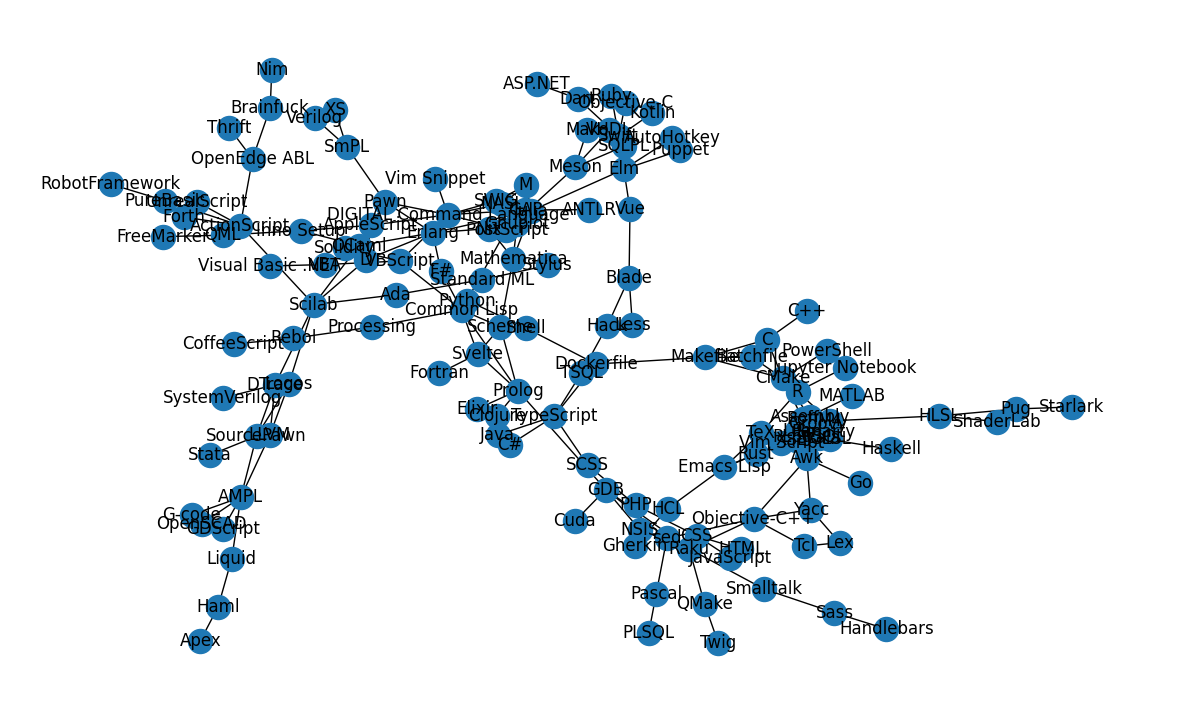

In [118]:
# network visual -- full software space
software_space_el = add_edges(mst_el, space_table, nr_edges_to_add=282)
ss_graph = nx.from_pandas_edgelist(software_space_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(ss_graph, with_labels=True, ax=ax)

In [120]:
# export for Herr Wachs
software_space_el.to_csv("../outputs/software_space_edgelist.csv", index=False, sep=";")

In [141]:
def software_space_of_country(el, complexity_table, country_code):
    # focal country
    ctable = complexity_table[complexity_table["iso2_code"]==country_code]
    
    # RCA filter
    ctable = ctable[ctable["rca"] >= 1]

    cel = pd.merge(
        el,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_1",
        right_on="language",
        how="left"
    )
    cel = pd.merge(
        cel,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_2",
        right_on="language",
        how="left",
        suffixes=["_i", "_j"]
    )

    # filter cel
    cel = cel.dropna(subset=["rca_i", "rca_j"])
    
    # clean up
    cel = cel[["language_1", "language_2", "proximity"]]

    return cel

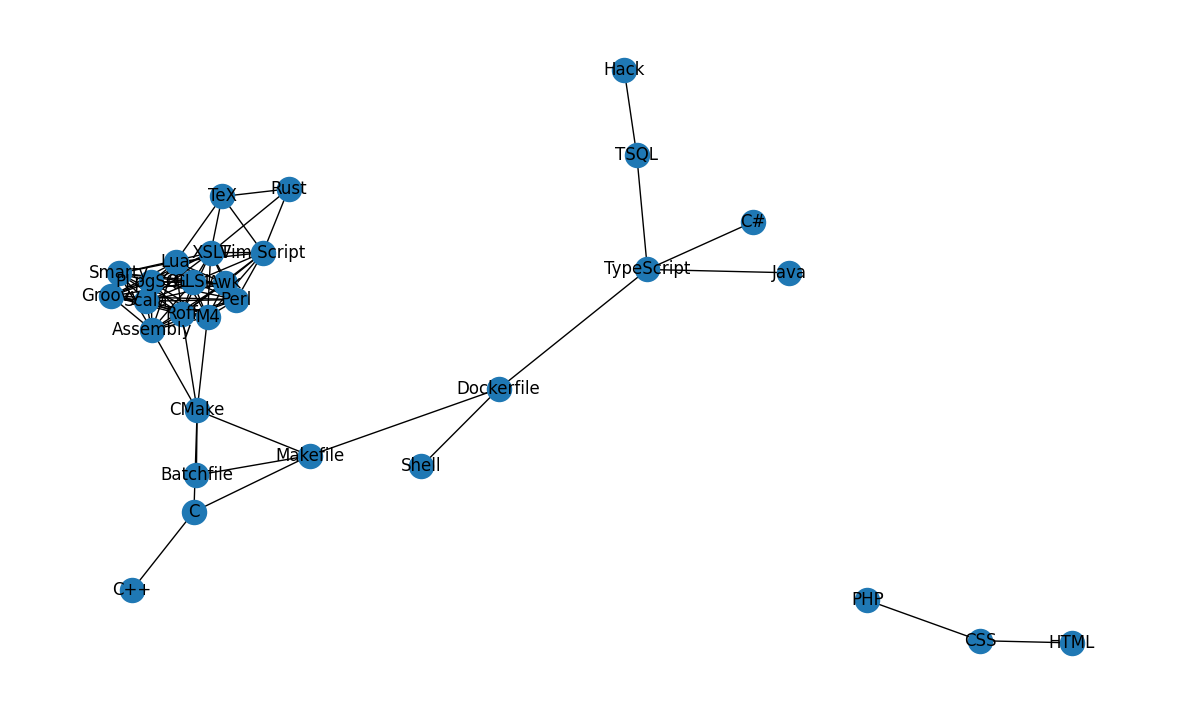

In [148]:
# hungary
selected_el = software_space_of_country(software_space_el, cdf, country_code="HU")
selected_graph = nx.from_pandas_edgelist(selected_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(selected_graph, with_labels=True, ax=ax)

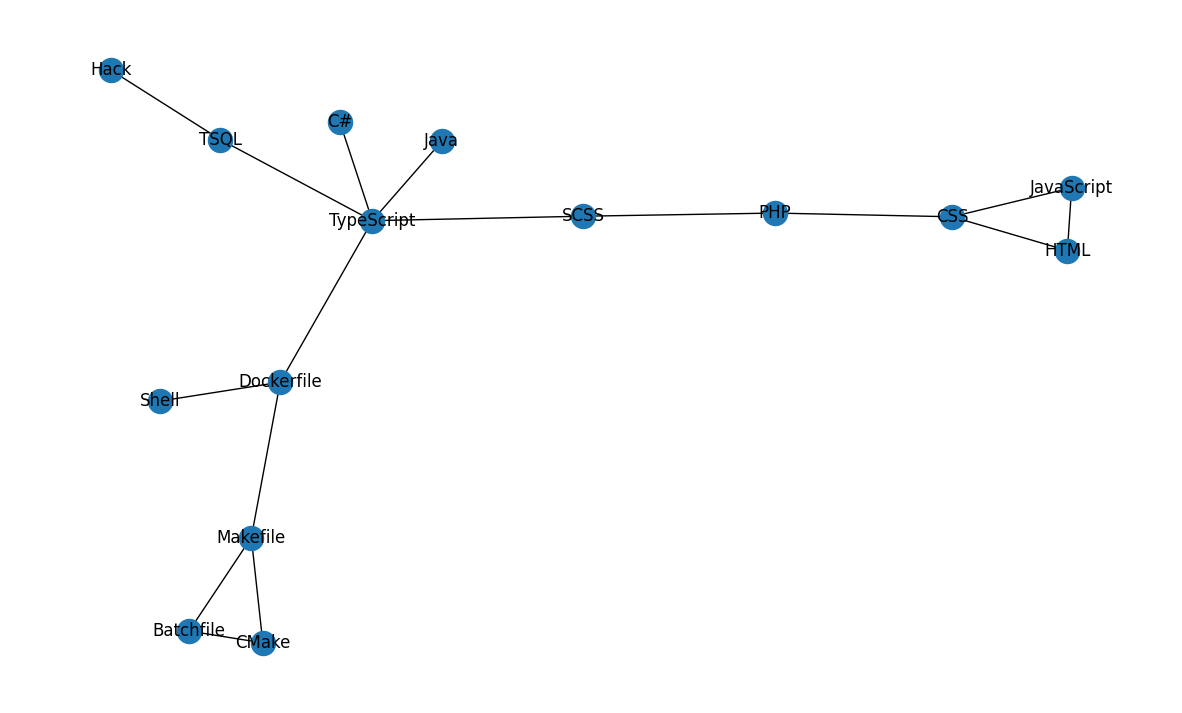

In [150]:
# estonia
selected_el = software_space_of_country(software_space_el, cdf, country_code="EE")
selected_graph = nx.from_pandas_edgelist(selected_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(selected_graph, with_labels=True, ax=ax)

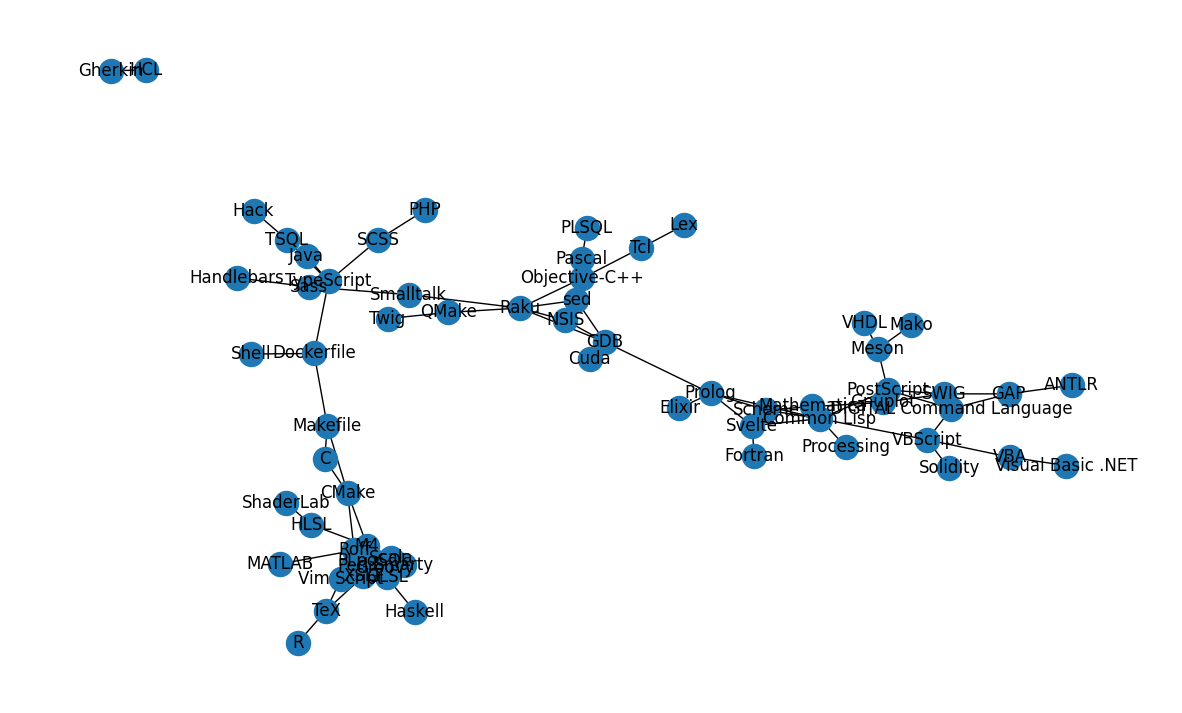

In [151]:
# spain
selected_el = software_space_of_country(software_space_el, cdf, country_code="ES")
selected_graph = nx.from_pandas_edgelist(selected_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(selected_graph, with_labels=True, ax=ax)

In [145]:
cdf.iso2_code.value_counts

<bound method IndexOpsMixin.value_counts of 0        AE
1        AE
2        AE
3        AE
4        AE
         ..
20869    ZW
20870    ZW
20871    ZW
20872    ZW
20873    ZW
Name: iso2_code, Length: 20874, dtype: object>

In [123]:
software_space_el.head(2)

,language_1,language_2,proximity,drop
0,AMPL,G-code,0.833333,1.0
1,AMPL,GDScript,0.750000,1.0


In [156]:
# dataframe for regression
